In [128]:
# !pip list --format=freeze > requirements.txt

# TODO

# Optiver Realized Volatility Prediction

# Problématique

La société Optive, une société de négoce pour compte propre et un teneur de marché pour divers instruments financiers, a lancée un concours sur Kaggle.  
Il s'agit de prédire la volatilité de "stocks" financiers.

## Terminologie

**Stock** : action financière  
**Order book** (Carnet d'ordres)  
Liste électronique d'ordres d'achat et de vente pour un titre ou un instrument financier spécifique organisé par niveau de prix.  
Les ordres d'achat prévus sont sur le côté gauche affichés comme "bid" tandis que tous les ordres de vente prévus sont sur la droite côté du livre affiché comme "ask"  
</br>
<img src="./img/OrderBook3.png" width="200px">  
</br>
**Trade book** (carnets de transactions effectuées)  
Un carnet d'ordres est une représentation de l'intention de négociation sur le marché, mais le marché a besoin d'un acheteur et d'un vendeur au même prix pour que la transaction se produise.  
Le trade book trace l'ensemble des transactions qui ont eu lieu

**bid/ask spread**  
</br>
<img src="./img/spread.png" width="350px">
</br></br>
**WAP** (Weighted averaged price)  
</br>
<img src="./img/wap.png" width="450px">  
</br></br>
**Log return** 
Permet de comparer le cours d'une action entre deux moments.  
En appelant St le prix de l'action S à l'instant t , nous pouvons définir le retour de log entre t1 et t2 comme
</br>
<img src="./img/logrtn.png" width="200px">  
</br>

**Volatilité** 
Grâce aux calculs des log return sur toutes les données consécutives du book nous pouvons définir la volatilité réalisée.  
Il s'agit de la racine carrée de la somme des log return au carré.
</br>
<img src="./img/volatility.png" width="200px">  
</br>

# Description du dataset

Le dataset est constitué de données financières et plus particulièrement de carnets d'ordres et de carnets de transactions effectuées.  
Ces deux "book" sont deux ensembles de fichiers séparés.

Chaque book est classé par stock qui représente un indice financier.  
Pour chaque stock nous avons plusieurs time_id.  
Celles ci font référence à une fenêtre de valeurs réelles de 20 min. Elles ne sont pas chronologiquement consécutives.
Certains de ces time_id sont publiques et font partie de l'échantillon train, d'autres sont caché et constituent l'échantillon de test.

Dans chacune de ces fenêtres de 20 min nous avons accès aux premières 10 min de données et nous devons prédire la volatilité des 10 min suivantes. 
La volatilité de ces dernières 10 min nous est fournie (pour l'échantillon train) et sera notre target.

<img src="./img/DataBucketing.webp" width="300px">  
</br>
</br>
Example et explication :
</br>
<img src="./img/Data_chart.png" width="800px"></br>
<img src="./img/Data_explainations.PNG" width="600px">


# Process machine learning

Il s'agit d'un problème de régression supervisé.

Dans un premier temps nous effectuerons un nettoyage éventuel et explorerons nos données.  
Puis nous Ferons du feature engineering sur nos dataset de book et trade.

## Evaluation

L'évaluation des performances de nos prédictions par rapport aux données de l'échantillon de test se fera avec le RMSPE (Root mean square percentage error)
</br>
<img src="./img/RMSPE.PNG" width="300px"></br>

Il faut agréger nos données sur un seul dataframe avec une ligne par time_id avant d'entraîner et appliquer un modèle.  
En effet voici la structure que devra avoir notre prédiction :
</br>
<img src="./img/sub_form.PNG" width="300px"></br>

Ici la colonne row_id est composé de {stock}-{time_id} et target est la prédiction de notre volatilité.

## Références

Ces Kernels m'ont particulièrement aidé dans ma participation :

[https://www.kaggle.com/alexioslyon/lgbm-baseline](https://www.kaggle.com/alexioslyon/lgbm-baseline)  
[https://www.kaggle.com/munumbutt/feature-engineering-tuned-xgboost-lgbm](https://www.kaggle.com/munumbutt/feature-engineering-tuned-xgboost-lgbm)

# Librairies

In [129]:
%matplotlib inline
# generic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from joblib import Parallel, delayed
import pickle
import time
import plotly.graph_objects as go

# machine learning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, make_scorer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
import optuna
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# path and files treatment
import glob
import os

# Variables

In [130]:
# env could be 'local' or 'kaggle'
env = 'local'

if env == 'local':
    data_folder = './data'
    output = './output/'
    save_path = './img/'
    if not(os.path.exists(output)):
        os.makedirs(output)
    if not(os.path.exists(save_path)):
        os.makedirs(save_path)    

elif env == 'kaggle':
    data_folder = '../input/optiver-realized-volatility-prediction'
    output = './output/'
    save_path = './img/'
    os.makedirs(save_path)
    os.makedirs(output)
else:
    print('env variable must be defined')

bk_train_fol = '/book_train.parquet/'
td_train_fol = '/trade_train.parquet/'
bk_test_fol = '/book_test.parquet/'
td_test_fol = '/trade_test.parquet/'

model_final = 'finalized_model.sav'

RANDOM_SEED = 42

# Remove non efficient (and slow) cells to be faster
fast = False

# if None take all the dataset
number_of_stocks = 2

pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

# Exploration

## Functions

In [131]:
def load_df(df_folder, nb_stock_to_load=0, data_folder=data_folder):
    '''load a parquet 
    
    arguments
    ---------------
    data_folder (str)
    df_folder (str)
    nb_stock_to_load (int)
        number of subfolders to load
    '''
    stock_list = os.listdir(data_folder + df_folder)

    if nb_stock_to_load == 0:
        nb_stock_to_load = len(stock_list)
    nb_stock_to_load = min(nb_stock_to_load, len(stock_list))
    
    if nb_stock_to_load == 1:
        df = pd.read_parquet(data_folder + df_folder + '/stock_id=0')
        df['stock_id'] = 0
    else:
        ## depreciated
        # subset_paths = []
        # for stock in stock_list[:nb_stock_to_load]:
        #     subset_path = glob.glob(data_folder + df_folder + stock + '/*')
        #     subset_paths.append(subset_path[0])

        subset_paths = [glob.glob(data_folder + df_folder + stock + '/*')[0] for stock in stock_list[:nb_stock_to_load]]
        ## doesn't work
        # subset_paths = glob.glob(data_folder + df_folder + '/*')[:nb_stock_to_load]
        
        df = pd.read_parquet(subset_paths)
        df['stock_id'] = df['stock_id'].astype(int)
    return df

## Book train 


In [132]:
book_train = load_df(bk_train_fol, nb_stock_to_load=1)
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [133]:
book_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917553 entries, 0 to 917552
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            917553 non-null  int16  
 1   seconds_in_bucket  917553 non-null  int16  
 2   bid_price1         917553 non-null  float32
 3   ask_price1         917553 non-null  float32
 4   bid_price2         917553 non-null  float32
 5   ask_price2         917553 non-null  float32
 6   bid_size1          917553 non-null  int32  
 7   ask_size1          917553 non-null  int32  
 8   bid_size2          917553 non-null  int32  
 9   ask_size2          917553 non-null  int32  
 10  stock_id           917553 non-null  int64  
dtypes: float32(4), int16(2), int32(4), int64(1)
memory usage: 38.5 MB


### Sample

In [134]:
# Sample
book_train_sample = book_train[(book_train['stock_id'] == 0) & (book_train['time_id'] < 35)].copy()
add_wap(book_train_sample)
fig = px.line(book_train_sample, x="seconds_in_bucket", y="wap1", title='WAP of stock_id_0, time_id <35', color='time_id')
if env == 'local' or env == 'kaggle':
    fig.write_image(save_path + 'wap_sample.png')
fig.show()

In [135]:
book_train_sample['log_return'] = book_train_sample.groupby(['time_id'])['wap1'].apply(log_return)
book_train_sample = book_train_sample[~book_train_sample['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

In [136]:
fig = px.line(book_train_sample, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id <35', color='time_id')
if env == 'local' or env == 'kaggle':
    fig.write_image(save_path + 'logreturn_sample.png')
fig.show()

In [137]:
# Realized volatility on our sample
realized_vol = book_train_sample.groupby(['time_id'])['log_return'].agg(realized_volatility)
print('Realized volatility for stock_id 0 :')
for i in realized_vol.index:
    print(f'- time_id {i} is {round(realized_vol.loc[i], 7)}')

Realized volatility for stock_id 0 :
- time_id 5 is 0.0044994
- time_id 11 is 0.0012044
- time_id 16 is 0.0023685
- time_id 31 is 0.0025738


## Trade train 

In [138]:
# Test tp know if the book and trade data are on same stocks
os.listdir(data_folder + td_train_fol) == os.listdir(data_folder + bk_train_fol)

True

In [139]:
trade_train = load_df(td_train_fol, nb_stock_to_load=2)

In [140]:
trade_train.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


### Sample

In [141]:
trade_train_sample = trade_train[(trade_train.stock_id == 0) & (trade_train.time_id < 35)]

fig = px.line(trade_train_sample, x="seconds_in_bucket", y="price", title='Price of stock_id_0, time_id <35', color='time_id')
if env == 'local' or env == 'kaggle':
    fig.write_image(save_path + 'trade_prices_sample.png')
fig.show()

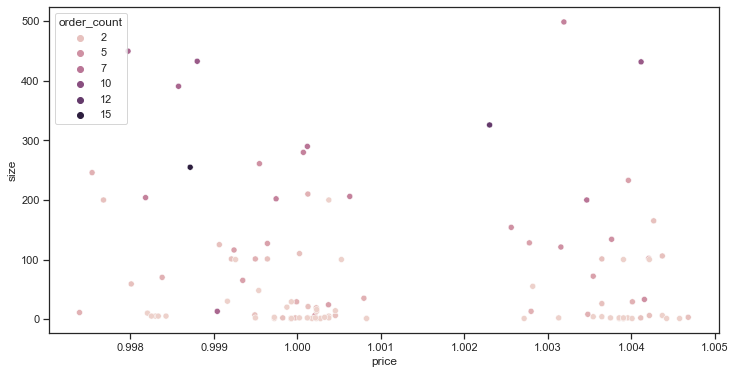

In [142]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=trade_train_sample, x="price", y="size", hue="order_count")
if env == 'local' or env == 'kaggle':
    plt.savefig(save_path + 'trade_sample.png')

plt.show()

## Book/Trade test

These file are here just to show the shape and firsts value of the hidden 10 min window.

In [143]:
book_test = load_df(bk_test_fol)
book_test.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24,0
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20,0
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15,0


In [144]:
trade_test = load_df(td_test_fol)
trade_test.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,4,7,1.000344,1,1,0
1,4,24,1.000049,100,7,0
2,4,27,1.000059,100,3,0


## Targets / realized volatility

In [145]:
# this dataset is just a sample, it will be replaced by the real one at each submission.
vol_test = pd.read_csv(data_folder +'/test.csv')
vol_test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [146]:
vol_train = pd.read_csv(data_folder +'/train.csv')
vol_train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [147]:
vol_train.shape

(428932, 3)

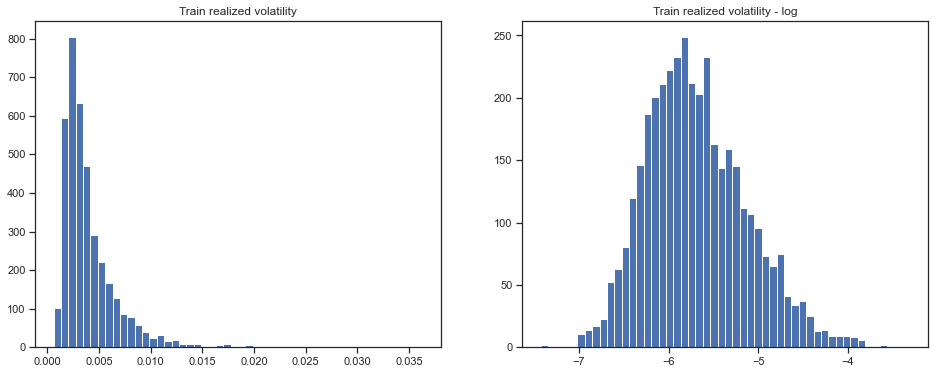

In [148]:
vol_stock0 = vol_train[vol_train['stock_id'] == 0]

sns.set_theme(style="ticks")
fig = plt.figure(figsize=(16, 6))
# fig.suptitle('Images after equalization preprocessing', fontsize=16)
# fig.tight_layout()

plt.subplot(1, 2, 1)
plt.title("Train realized volatility")
plt.hist(vol_stock0['target'], bins=50)

plt.subplot(1, 2, 2)
plt.title("Train realized volatility - log")
plt.hist(np.log(vol_stock0['target']), bins=50)

if env == 'local' or env == 'kaggle':
    plt.savefig(save_path + 'realized_volatility.png')

plt.show()

# Preprocessing & baseline
---


## Functions

In [149]:
###############################
# Functions to add features
###############################

def add_wap(df, number=1, column_prefix='wap', standard=True):
    '''adding one wap

    number (int): the position of the price to take it could be 1 or 2
    standard (bool): use standard method to calculate wap or use a custom method
    '''
    if standard:
        df[column_prefix + str(number)] = (
            df['bid_price'+ str(number)] * df['ask_size'+ str(number)] + df['ask_price'+ str(number)] * df['bid_size'+ str(number)]) / (
                df['ask_size'+ str(number)]+ df['bid_size'+ str(number)])
    else:
        df[column_prefix + str(number) + '_ns'] = (
            df['bid_price'+ str(number)] * df['bid_size'+ str(number)] + df['ask_price'+ str(number)] * df['ask_size'+ str(number)]) / (
                df['ask_size'+ str(number)]+ df['bid_size'+ str(number)])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def add_waps(df):
        '''add many waps'''
        add_wap(df, 1, column_prefix='wap')
        add_wap(df, 2, column_prefix='wap')
        add_wap(df, 1, column_prefix='wap', standard=False)
        add_wap(df, 2, column_prefix='wap', standard=False)
        df['wap_p'] = ((
                df['wap1'] * (df['ask_size1'] + df['bid_size1']) +
                df['wap2'] * (df['ask_size2'] + df['bid_size2'])) /
                (df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']))
        df['wap_balance'] = abs(df['wap1'] - df['wap2'])

def add_log_return(df, price_col, log_col_name, group='time_id'):
        df[log_col_name] = df.groupby([group])[price_col].apply(log_return)

def add_spreads(df):
        # # tests with ponderates features
        # df['bid_spread_p'] = (df['bid_price1'] * df['bid_size1'] - df['bid_price2'] * df['bid_size1'])/(df['bid_size1'] + df['bid_size2'])
        # df['ask_spread_p'] = (df['ask_price1'] * df['ask_size1'] - df['ask_price2'] * df['ask_size1'])/(df['ask_size1'] + df['ask_size2'])
        # df["bid_ask_spread_p"] = abs(df['bid_spread_p'] - df['ask_spread_p'])
        df['bid_spread'] = df['bid_price1'] - df['bid_price2']
        df['ask_spread'] = df['ask_price1'] - df['ask_price2']
        df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
        df["bid_ask_spread1"] = (df['ask_price1'] - df['bid_price1'])/df['bid_price1']
        df["bid_ask_spread2"] = (df['ask_price2'] - df['bid_price2'])/df['bid_price2']
        df["bid_ask_spread_p"] = ((df['ask_price1'] + df['ask_price2']) - (df['bid_price1'] + df['bid_price2']))/(df['bid_price1'] + df['bid_price2'])

def add_volumes(df):
        df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
        df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

def add_EMA(df, wap_col, nb_period):
        df[wap_col + '_' + str(nb_period) + 'sec_EWM'] = df[wap_col].ewm(span=nb_period, adjust=False).mean()

###############################
# Evaluation
###############################
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [150]:
###############################
# Lists of dataset paths
###############################

# Create a list of stocks paths books from the dataset
if number_of_stocks is None:
    list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '*')
    list_order_trade_file_train = glob.glob(data_folder + td_train_fol + '*')
    stock_id_max = max([int(path.split('=')[1]) for path in list_order_trade_file_train]) # files on kaggle are random sorted
else:
    stock_id_max = number_of_stocks-1 # stocks start at 0
    # take only stocks <= stock_id_max
    list_order_book_file_train = [path for path in glob.glob(data_folder + bk_train_fol + '*') if int(path.split('=')[1]) <= stock_id_max]
    list_order_trade_file_train = [path for path in glob.glob(data_folder + td_train_fol + '*') if int(path.split('=')[1]) <= stock_id_max]


## Naive RMSPE

Un fait bien connu à propos de la volatilité est qu'elle a tendance à être autocorrélée. Nous pouvons utiliser cette propriété pour implémenter un modèle naïf qui "prédit" simplement la volatilité réalisée en utilisant la volatilité réalisée au cours des 10 premières minutes.

Calculons la volatilité réalisée de la première partie de la fenêtre sur le jeu de donnée train.

In [151]:
# select all stocks books
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '/*')
list_order_book_file_train[:2] # sample

['./data/book_train.parquet\\stock_id=0',
 './data/book_train.parquet\\stock_id=1']

In [152]:
# specific for naive model
def realized_volatility_per_time_id(file_path, prediction_column_name):
    '''load datas of one stock_id then calculate WAP, log_return
    set a new DF and put inside realized_volatility per time_id
    add a column with competition form : {stock_id}-{time_id} called row_id

    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0
    prediction_column_name : name of the realized_volatility column
    
    return row_id, prediction_name columns'''
    df_book_data = pd.read_parquet(file_path)
    add_wap(df_book_data)

    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap1'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [153]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

# test on all 126 stocks 
# long ! 230 sec
if not(fast):
    df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                            prediction_column_name='pred')
    df_past_realized_train.head()

In [154]:
if not(fast):
    df_naive = vol_train.copy()
    # Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.
    # naive prediction = predict same volatility in the next 10min window (auto realisation)
    df_naive['row_id'] = df_naive['stock_id'].astype(str) + '-' + df_naive['time_id'].astype(str)
    df_naive = df_naive[['row_id','target']]
    df_naive = df_naive.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')
    df_naive.head()

In [155]:
if not(fast):
    R2 = round(r2_score(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
    RMSPE = round(rmspe(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
    print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


## Order book train

**Process flow**  
</br>
<img src="./img/p8_process_orders.png" width="900px"></br>

In [156]:
# list of waps for applying log return, EMA and EMA log return
# this list is also used in the creation of aggregation dic
waps = ['wap1', 'wap2', 'wap1_ns', 'wap2_ns', 'wap_p']

def book_feature_eng_per_stock(file_path, waps=waps):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0

    return the df '''
    book_train = pd.read_parquet(file_path)

    add_waps(book_train)
    
    for wap in waps:
        add_log_return(book_train, price_col=wap, log_col_name=wap + '_log_return')
        for period in  [20, 100]:
            add_EMA(book_train, wap, period)
            EMA_col_name = wap + '_' + str(period) + 'sec_EWM'
            add_log_return(book_train, price_col=EMA_col_name, log_col_name=EMA_col_name + '_log_return')
            book_train['diff_' + EMA_col_name] = abs(book_train[wap] - book_train[EMA_col_name])
    
    add_spreads(book_train)
    add_volumes(book_train)

    # book_train = book_train[~(book_train['wap1_log_return'].isnull() | book_train['log_return2'].isnull() | book_train['log_return_p'].isnull())] # at the end ?
    book_train = book_train.fillna(book_train.median())
    
    return book_train

In [157]:
# sample with stock 0
df_sample = book_feature_eng_per_stock(list_order_book_file_train[0])
df_sample.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,wap1_ns,wap2_ns,wap_p,wap_balance,wap1_log_return,wap1_20sec_EWM,wap1_20sec_EWM_log_return,diff_wap1_20sec_EWM,wap1_100sec_EWM,wap1_100sec_EWM_log_return,diff_wap1_100sec_EWM,wap2_log_return,wap2_20sec_EWM,wap2_20sec_EWM_log_return,diff_wap2_20sec_EWM,wap2_100sec_EWM,wap2_100sec_EWM_log_return,diff_wap2_100sec_EWM,wap1_ns_log_return,wap1_ns_20sec_EWM,wap1_ns_20sec_EWM_log_return,diff_wap1_ns_20sec_EWM,wap1_ns_100sec_EWM,wap1_ns_100sec_EWM_log_return,diff_wap1_ns_100sec_EWM,wap2_ns_log_return,wap2_ns_20sec_EWM,wap2_ns_20sec_EWM_log_return,diff_wap2_ns_20sec_EWM,wap2_ns_100sec_EWM,wap2_ns_100sec_EWM_log_return,diff_wap2_ns_100sec_EWM,wap_p_log_return,wap_p_20sec_EWM,wap_p_20sec_EWM_log_return,diff_wap_p_20sec_EWM,wap_p_100sec_EWM,wap_p_100sec_EWM_log_return,diff_wap_p_100sec_EWM,bid_spread,ask_spread,price_spread,bid_ask_spread1,bid_ask_spread2,bid_ask_spread_p,total_volume,volume_imbalance
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,1.001434,1.001390,1.002290,1.002334,1.001420,0.000044,0.000000,1.001434,5.232947e-07,0.000000,1.001434,4.054438e-08,0.000000,0.000000,1.00139,3.420339e-07,0.000000e+00,1.00139,3.120546e-08,0.000000e+00,0.000000,1.002290,6.240393e-08,0.000000,1.002290,-2.380864e-08,0.000000,0.000000,1.002334,2.264837e-07,0.000000,1.002334,-6.993950e-09,0.000000,0.000000e+00,1.00142,3.900371e-07,0.000000e+00,1.00142,1.297746e-08,0.000000e+00,0.000052,-0.000052,0.000878,0.000878,0.000981,0.000930,331,321
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,1.001390,1.002276,1.002334,1.001419,0.000058,0.000014,1.001435,1.339922e-06,0.000013,1.001434,2.785977e-07,0.000014,0.000000,1.00139,0.000000e+00,0.000000e+00,1.00139,0.000000e+00,0.000000e+00,-0.000014,1.002288,-1.338779e-06,0.000013,1.002290,-2.783598e-07,0.000014,0.000000,1.002334,0.000000e+00,0.000000,1.002334,0.000000e+00,0.000000,-1.250457e-06,1.00142,-1.190911e-07,1.132972e-06,1.00142,-2.476152e-08,1.227436e-06,0.000052,-0.000052,0.000878,0.000878,0.000981,0.000930,205,195
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,1.001391,1.002276,1.002385,1.001419,0.000057,0.000000,1.001436,1.212309e-06,0.000012,1.001434,2.730809e-07,0.000014,0.000001,1.00139,9.647998e-08,9.178336e-07,1.00139,2.006020e-08,9.943596e-07,0.000000,1.002287,-1.211278e-06,0.000012,1.002289,-2.728478e-07,0.000014,0.000051,1.002339,4.819444e-06,0.000046,1.002335,1.002065e-06,0.000050,5.040343e-07,1.00142,-5.974589e-08,5.683919e-07,1.00142,-1.429032e-08,7.083756e-07,0.000052,-0.000103,0.000878,0.000878,0.001033,0.000955,205,195
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,1.001391,1.002281,1.002385,1.001420,0.000052,-0.000005,1.001437,6.060242e-07,0.000006,1.001434,1.656202e-07,0.000008,0.000000,1.00139,8.729140e-08,8.304209e-07,1.00139,1.966296e-08,9.746693e-07,0.000005,1.002287,-6.055100e-07,0.000006,1.002289,-1.654790e-07,0.000008,0.000000,1.002343,4.360429e-06,0.000042,1.002336,9.822207e-07,0.000049,3.130015e-07,1.00142,-2.424616e-08,2.306656e-07,1.00142,-7.809303e-09,3.871094e-07,0.000052,-0.000103,0.000878,0.000878,0.001033,0.000955,231,221
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,1.001391,1.002281,1.002385,1.001420,0.000052,0.000000,1.001437,5.483073e-07,0.000005,1.001435,1.623406e-07,0.000008,0.000000,1.00139,7.897793e-08,7.513332e-07,1.00139,1.927360e-08,9.553689e-07,0.000000,1.002286,-5.478427e-07,0.000005,1.002289,-1.622022e-07,0.000008,0.000000,1.002347,3.945134e-06,0.000038,1.002337,9.627698e-07,0.000048,0.000000e+00,1.00142,-2.193700e-08,2.086974e-07,1.00142,-7.654663e-09,3.794439e-07,0.000052,-0.000103,0.000878,0.000878,0.001033,0.000955,231,221


In [158]:
# list of spreads to apply the aggregate functions
spreads = ['bid_ask_spread1', 'bid_ask_spread2', 'bid_ask_spread_p', 'bid_spread', 'ask_spread', 'price_spread']

#########################################
# Creation of order book aggregation dic
#########################################
bk_feature_dic = {}
for wap in waps:
    bk_feature_dic[wap + '_log_return'] = [realized_volatility]
    # bk_feature_dic[wap] = [np.std, pd.Series.mad]
    for period in [20, 100]:
        EMA_col_name = wap + '_' + str(period) + 'sec_EWM'
        # bk_feature_dic[EMA_col_name + '_log_return'] = [realized_volatility]
        bk_feature_dic['diff_' + EMA_col_name] = [np.sum, np.std]
for spread in spreads:
    bk_feature_dic[spread] = [np.sum, np.std]

bk_feature_dic['total_volume'] = [np.sum, np.mean]
bk_feature_dic['volume_imbalance'] = [np.std]
bk_feature_dic['wap_balance'] = [np.sum, np.mean]

bk_feature_dic

{'wap1_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'diff_wap1_20sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'diff_wap1_100sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'wap2_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'diff_wap2_20sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'diff_wap2_100sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>

In [159]:
def book_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id and apply the feature dic
    add :
    - a stock_id columns
    - a competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = book_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(bk_feature_dic).reset_index())

    df_agg_stock.columns = ['_'.join(col).rstrip('_') for col in df_agg_stock.columns.values]
    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock

In [160]:
def agg_df_and_concatenate_parallel(paths_list, func):
    ''' Create an concateneted df of preprocessed stocks df by the func'''

    df_agg = Parallel(n_jobs=-1)(
        delayed(func)(file) 
        for file in paths_list)
    
    df_agg = pd.concat(df_agg, ignore_index = True)

    return df_agg

In [161]:
%%time
df_order_agg = agg_df_and_concatenate_parallel(list_order_book_file_train, book_agg_form_parallele)
df_order_agg.head()

Wall time: 10min 50s


,wap1_log_return_realized_volatility,diff_wap1_20sec_EWM_sum,diff_wap1_20sec_EWM_std,diff_wap1_100sec_EWM_sum,diff_wap1_100sec_EWM_std,wap2_log_return_realized_volatility,diff_wap2_20sec_EWM_sum,diff_wap2_20sec_EWM_std,diff_wap2_100sec_EWM_sum,diff_wap2_100sec_EWM_std,wap1_ns_log_return_realized_volatility,diff_wap1_ns_20sec_EWM_sum,diff_wap1_ns_20sec_EWM_std,diff_wap1_ns_100sec_EWM_sum,diff_wap1_ns_100sec_EWM_std,wap2_ns_log_return_realized_volatility,diff_wap2_ns_20sec_EWM_sum,diff_wap2_ns_20sec_EWM_std,diff_wap2_ns_100sec_EWM_sum,diff_wap2_ns_100sec_EWM_std,wap_p_log_return_realized_volatility,diff_wap_p_20sec_EWM_sum,diff_wap_p_20sec_EWM_std,diff_wap_p_100sec_EWM_sum,diff_wap_p_100sec_EWM_std,bid_ask_spread1_sum,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_std,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_spread_sum,bid_spread_std,ask_spread_sum,ask_spread_std,price_spread_sum,price_spread_std,total_volume_sum,total_volume_mean,volume_imbalance_std,wap_balance_sum,wap_balance_mean,row_id
0,0.004499,0.082547,0.000272,0.165881,0.000570,0.006999,0.109628,0.000295,0.186148,0.000604,0.005466,0.084248,0.000230,0.154278,0.000346,0.006119,0.097241,0.000253,0.160807,0.000351,0.004106,0.081467,0.000268,0.168413,0.000586,0.257371,0.000212,0.355667,0.000213,0.306512,0.000181,0.053006,0.000162,-0.045557,0.000126,0.257255,0.000211,97696,323.496689,107.260583,0.117051,0.000388,0-5
1,0.001204,0.043660,0.000487,0.164762,0.000931,0.002476,0.055434,0.000453,0.165895,0.000888,0.001782,0.051586,0.000460,0.172366,0.000928,0.002320,0.055202,0.000433,0.168873,0.000941,0.001507,0.045247,0.000477,0.162362,0.000916,0.078854,0.000157,0.134231,0.000200,0.106541,0.000162,0.028358,0.000148,-0.027001,0.000065,0.078836,0.000157,82290,411.450000,102.139758,0.042312,0.000212,0-11
2,0.002369,0.045025,0.000175,0.094222,0.000422,0.004801,0.059518,0.000254,0.099893,0.000444,0.002624,0.039023,0.000202,0.078405,0.000361,0.004684,0.057685,0.000254,0.102776,0.000405,0.002469,0.045988,0.000190,0.092495,0.000428,0.136382,0.000164,0.210689,0.000295,0.173527,0.000212,0.036955,0.000170,-0.037243,0.000171,0.136330,0.000164,78274,416.351064,108.891243,0.062228,0.000331,0-16
3,0.002574,0.050326,0.000432,0.068660,0.000382,0.003637,0.047012,0.000355,0.062021,0.000321,0.002356,0.038967,0.000315,0.051631,0.000322,0.002881,0.045254,0.000443,0.062843,0.000409,0.002709,0.047261,0.000407,0.061970,0.000359,0.103301,0.000280,0.139155,0.000366,0.121226,0.000308,0.022764,0.000199,-0.013001,0.000091,0.103252,0.000280,52232,435.266667,121.533215,0.045611,0.000380,0-31
4,0.001894,0.033966,0.000279,0.066749,0.000316,0.003257,0.041370,0.000255,0.068746,0.000326,0.002118,0.028450,0.000203,0.050618,0.000267,0.003166,0.037818,0.000244,0.062390,0.000270,0.001932,0.032904,0.000274,0.066500,0.000326,0.069917,0.000130,0.122744,0.000185,0.096330,0.000146,0.033565,0.000083,-0.019206,0.000076,0.069901,0.000130,60407,343.221591,102.407501,0.044783,0.000254,0-62


---
## Trades book train


**Process flow**  
</br>
<img src="./img/p8_process_trades.png" width="900px"></br>

In [162]:
###############################
# Functions to add features
###############################
def add_amount(df):
    df['amount'] = df['price'] * df['size']
def add_power(df):
    df['power'] = (df['price'] - df['price'].shift(1))/df['price']*df['size']

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

In [163]:
def trade_feature_eng_per_stock(file_path):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/trade_train/stock_id=0

    return the df '''
    df = pd.read_parquet(file_path)
        
    add_log_return(df, price_col='price', log_col_name='td_log_return')

    add_amount(df)
    for period in  [20, 100]:
        add_EMA(df, 'amount', period)
        EMA_col_name = 'amount_' + str(period) + 'sec_EWM'
        add_log_return(df, price_col=EMA_col_name, log_col_name=EMA_col_name + '_log_return')
        
    df['diff_td'] = df.seconds_in_bucket.diff() # same Nan as log_return
    df['amount_p_order'] = df.amount / df.order_count
    add_power(df)

    df = df[~df['td_log_return'].isnull()]
    return df

In [164]:
# sample with stock 0
df_sample = trade_feature_eng_per_stock(list_order_trade_file_train[0])
df_sample.head()

,time_id,seconds_in_bucket,price,size,order_count,td_log_return,amount,amount_20sec_EWM,amount_20sec_EWM_log_return,amount_100sec_EWM,amount_100sec_EWM_log_return,diff_td,amount_p_order,power
1,5,46,1.002778,128,4,0.000476,128.355591,307.855507,-0.059566,322.821628,-0.012096,25.0,32.088898,0.060851
2,5,50,1.002818,55,1,0.000040,55.155016,283.788794,-0.081400,317.521300,-0.016555,4.0,55.155016,0.002216
3,5,57,1.003155,121,5,0.000336,121.381797,268.321461,-0.056045,313.637349,-0.012308,7.0,24.276359,0.040635
4,5,68,1.003646,4,1,0.000489,4.014584,243.149377,-0.098510,307.506205,-0.019742,11.0,4.014584,0.001955
5,5,78,1.003762,134,5,0.000116,134.504173,232.802215,-0.043487,304.080422,-0.011203,10.0,26.900835,0.015564


In [165]:
#########################################
# Creation of order book aggregation dic
#########################################
td_feature_dic = {}
for period in  [20, 100]:
    EMA_col_name = 'amount_' + str(period) + 'sec_EWM_log_return'
    td_feature_dic[EMA_col_name] = [realized_volatility]
td_feature_dic['td_log_return'] = [realized_volatility]
# td_feature_dic['seconds_in_bucket'] = [count_unique] # removed after feature importance analysis
td_feature_dic['diff_td'] = [np.std]
td_feature_dic['amount_p_order'] = [np.mean]
td_feature_dic['price'] = [np.mean]
td_feature_dic['amount'] = [np.std, pd.Series.mad]
td_feature_dic['amount_p_order'] = [np.mean, np.sum]
# td_feature_dic['size'] = [np.mean, np.sum] # removed after feature importance analysis
td_feature_dic['order_count'] = [np.mean, np.sum]

td_feature_dic

{'amount_20sec_EWM_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'amount_100sec_EWM_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'td_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'diff_td': [<function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'amount_p_order': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>],
 'price': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>],
 'amount': [<function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>,
  <function pandas.core.generic.NDFrame._add_numeric_operations.<locals>.mad(self, axis=None, skipna=None, level=None)>],
 'order_count': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,


In [166]:
def trade_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = trade_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(td_feature_dic)).reset_index()
    
    df_agg_stock.columns = ['_'.join(col).rstrip('_') for col in df_agg_stock.columns.values]
    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock


In [167]:
%%time
df_trade_agg = agg_df_and_concatenate_parallel(list_order_trade_file_train, trade_agg_form_parallele)
df_trade_agg.head()

Wall time: 6.28 s


,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,amount_std,amount_mad,order_count_mean,order_count_sum,row_id
0,0.810606,0.107992,0.002006,12.661267,23.100317,900.912351,1.003759,113.282652,79.821339,2.512821,98,0-5
1,0.960455,0.095978,0.000901,14.681344,20.724629,601.014231,1.000219,78.820060,57.928094,1.896552,55,0-11
2,0.758793,0.099807,0.001961,19.381748,26.498888,635.973322,0.999162,114.491758,93.426704,2.791667,67,0-16
3,0.479299,0.095522,0.001561,32.636611,34.936621,489.112699,0.998933,146.206953,111.716741,4.142857,58,0-31
4,0.538092,0.100346,0.000871,17.502789,16.893227,354.757776,0.999599,119.362773,98.158010,4.190476,88,0-62


---
## Final DF train

In [168]:
def process_final_df(df_order_agg, df_trade_agg, df_target):
    '''select the targets of the chosen stocks
    merge target df to order and trades df
    return new df'''

    df = df_target[df_target.stock_id <= stock_id_max].copy()
    #  adding the same index in our books df to merge
    df['row_id'] = df['stock_id'].astype(str) + '-' + df['time_id'].astype(str)

    df = df.merge(df_order_agg, on = ['row_id'], how = 'left')
    df = df.merge(df_trade_agg, on = ['row_id'], how = 'left')

    return df    

In [169]:
df_train = process_final_df(df_order_agg, df_trade_agg, vol_train)
df_train.head()

,stock_id,time_id,target,row_id,wap1_log_return_realized_volatility,diff_wap1_20sec_EWM_sum,diff_wap1_20sec_EWM_std,diff_wap1_100sec_EWM_sum,diff_wap1_100sec_EWM_std,wap2_log_return_realized_volatility,diff_wap2_20sec_EWM_sum,diff_wap2_20sec_EWM_std,diff_wap2_100sec_EWM_sum,diff_wap2_100sec_EWM_std,wap1_ns_log_return_realized_volatility,diff_wap1_ns_20sec_EWM_sum,diff_wap1_ns_20sec_EWM_std,diff_wap1_ns_100sec_EWM_sum,diff_wap1_ns_100sec_EWM_std,wap2_ns_log_return_realized_volatility,diff_wap2_ns_20sec_EWM_sum,diff_wap2_ns_20sec_EWM_std,diff_wap2_ns_100sec_EWM_sum,diff_wap2_ns_100sec_EWM_std,wap_p_log_return_realized_volatility,diff_wap_p_20sec_EWM_sum,diff_wap_p_20sec_EWM_std,diff_wap_p_100sec_EWM_sum,diff_wap_p_100sec_EWM_std,bid_ask_spread1_sum,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_std,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_spread_sum,bid_spread_std,ask_spread_sum,ask_spread_std,price_spread_sum,price_spread_std,total_volume_sum,total_volume_mean,volume_imbalance_std,wap_balance_sum,wap_balance_mean,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,amount_std,amount_mad,order_count_mean,order_count_sum
0,0,5,0.004136,0-5,0.004499,0.082547,0.000272,0.165881,0.000570,0.006999,0.109628,0.000295,0.186148,0.000604,0.005466,0.084248,0.000230,0.154278,0.000346,0.006119,0.097241,0.000253,0.160807,0.000351,0.004106,0.081467,0.000268,0.168413,0.000586,0.257371,0.000212,0.355667,0.000213,0.306512,0.000181,0.053006,0.000162,-0.045557,0.000126,0.257255,0.000211,97696,323.496689,107.260583,0.117051,0.000388,0.810606,0.107992,0.002006,12.661267,23.100317,900.912351,1.003759,113.282652,79.821339,2.512821,98
1,0,11,0.001445,0-11,0.001204,0.043660,0.000487,0.164762,0.000931,0.002476,0.055434,0.000453,0.165895,0.000888,0.001782,0.051586,0.000460,0.172366,0.000928,0.002320,0.055202,0.000433,0.168873,0.000941,0.001507,0.045247,0.000477,0.162362,0.000916,0.078854,0.000157,0.134231,0.000200,0.106541,0.000162,0.028358,0.000148,-0.027001,0.000065,0.078836,0.000157,82290,411.450000,102.139758,0.042312,0.000212,0.960455,0.095978,0.000901,14.681344,20.724629,601.014231,1.000219,78.820060,57.928094,1.896552,55
2,0,16,0.002168,0-16,0.002369,0.045025,0.000175,0.094222,0.000422,0.004801,0.059518,0.000254,0.099893,0.000444,0.002624,0.039023,0.000202,0.078405,0.000361,0.004684,0.057685,0.000254,0.102776,0.000405,0.002469,0.045988,0.000190,0.092495,0.000428,0.136382,0.000164,0.210689,0.000295,0.173527,0.000212,0.036955,0.000170,-0.037243,0.000171,0.136330,0.000164,78274,416.351064,108.891243,0.062228,0.000331,0.758793,0.099807,0.001961,19.381748,26.498888,635.973322,0.999162,114.491758,93.426704,2.791667,67
3,0,31,0.002195,0-31,0.002574,0.050326,0.000432,0.068660,0.000382,0.003637,0.047012,0.000355,0.062021,0.000321,0.002356,0.038967,0.000315,0.051631,0.000322,0.002881,0.045254,0.000443,0.062843,0.000409,0.002709,0.047261,0.000407,0.061970,0.000359,0.103301,0.000280,0.139155,0.000366,0.121226,0.000308,0.022764,0.000199,-0.013001,0.000091,0.103252,0.000280,52232,435.266667,121.533215,0.045611,0.000380,0.479299,0.095522,0.001561,32.636611,34.936621,489.112699,0.998933,146.206953,111.716741,4.142857,58
4,0,62,0.001747,0-62,0.001894,0.033966,0.000279,0.066749,0.000316,0.003257,0.041370,0.000255,0.068746,0.000326,0.002118,0.028450,0.000203,0.050618,0.000267,0.003166,0.037818,0.000244,0.062390,0.000270,0.001932,0.032904,0.000274,0.066500,0.000326,0.069917,0.000130,0.122744,0.000185,0.096330,0.000146,0.033565,0.000083,-0.019206,0.000076,0.069901,0.000130,60407,343.221591,102.407501,0.044783,0.000254,0.538092,0.100346,0.000871,17.502789,16.893227,354.757776,0.999599,119.362773,98.158010,4.190476,88


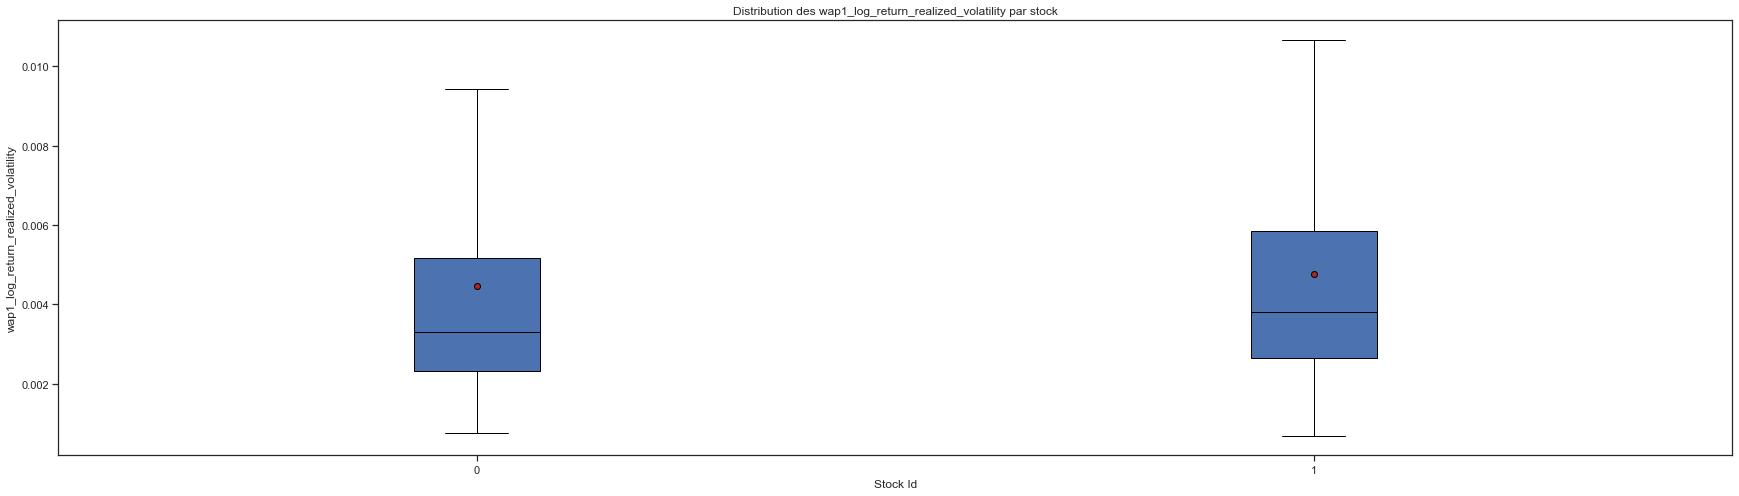

In [170]:
###########################################
# Ploting realized volatility per stock
###########################################

# #Création d'un sous échantillon par modalité
groupes = []
for s in df_train['stock_id'].unique():
    groupes.append(df_train[df_train['stock_id'] == s]['wap1_log_return_realized_volatility'])
 
# 'OO' méthode pour plot
fig, ax = plt.subplots(figsize=(30,8))

# Propriétés graphiques
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

ax.boxplot(groupes,
           labels=df_train['stock_id'].unique(),
           showfliers=False,
           medianprops=medianprops, 
           vert=True,
           patch_artist=True,
           showmeans=True,
           meanprops=meanprops)

ax.set(title='Distribution des wap1_log_return_realized_volatility par stock',
      xlabel="Stock Id",
      ylabel='wap1_log_return_realized_volatility')

plt.show()

In [171]:
###############################
# Saving preprocessed train ds
###############################
# df_train.to_pickle(output + 'dataset_train.bz2', compression='bz2')

## Test dataset

In [172]:
# list of test books paths
list_order_book_file_test = glob.glob(data_folder + bk_test_fol + '*')
list_order_trade_file_test = glob.glob(data_folder + td_test_fol + '*')

# preprocess test dataset
df_order_test_agg = agg_df_and_concatenate_parallel(list_order_book_file_test, book_agg_form_parallele)
df_trade_test_agg = agg_df_and_concatenate_parallel(list_order_trade_file_test, trade_agg_form_parallele)

# Merging df
df_test = process_final_df(df_order_test_agg, df_trade_test_agg, vol_test)

# Machine learning
---

### Functions and variables

In [206]:
# For optuna studies
n_trials = 10

kfolds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

scorer_rmspe = make_scorer(rmspe,
    # greater_is_better=False
    )

In [174]:
## New idea for the dic structure
# dic_eval = dict.fromkeys(['names', 'models', 'rmspe_scores', 'r2_scores'])
# dic_eval

In [175]:
dic_eval = {}
def evaluate(name, model, dic, X_test, y_test):
    y_pred = model.predict(X_test)
    R2 = round(r2_score(y_test, y_pred), 6)
    RMSPE = round(rmspe(y_test, y_pred), 6)
    dic[name] = [model, RMSPE, R2]
    print(f'Performance of the {name} prediction: R2 score: {R2}, RMSPE: {RMSPE}')

def evaluateCV(name, model, dic, X_train, y_train):
    start_time = time.time()
    RMSPE =  round(cross_val_score(
        model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean(), 6)
    # model.fit(X_train, y_train)
    dic[name] = [model, RMSPE]
    print(f'RMSPE of the {name} prediction: {RMSPE} in {round(time.time() - start_time, 3)} sec.')
    # return model

### Dataset

In [176]:
###############################
# Loading preprocessed train ds
###############################
# df_train = pd.read_pickle(output + 'dataset_train.bz2')

In [177]:
df_train.head()

,stock_id,time_id,target,row_id,wap1_log_return_realized_volatility,diff_wap1_20sec_EWM_sum,diff_wap1_20sec_EWM_std,diff_wap1_100sec_EWM_sum,diff_wap1_100sec_EWM_std,wap2_log_return_realized_volatility,diff_wap2_20sec_EWM_sum,diff_wap2_20sec_EWM_std,diff_wap2_100sec_EWM_sum,diff_wap2_100sec_EWM_std,wap1_ns_log_return_realized_volatility,diff_wap1_ns_20sec_EWM_sum,diff_wap1_ns_20sec_EWM_std,diff_wap1_ns_100sec_EWM_sum,diff_wap1_ns_100sec_EWM_std,wap2_ns_log_return_realized_volatility,diff_wap2_ns_20sec_EWM_sum,diff_wap2_ns_20sec_EWM_std,diff_wap2_ns_100sec_EWM_sum,diff_wap2_ns_100sec_EWM_std,wap_p_log_return_realized_volatility,diff_wap_p_20sec_EWM_sum,diff_wap_p_20sec_EWM_std,diff_wap_p_100sec_EWM_sum,diff_wap_p_100sec_EWM_std,bid_ask_spread1_sum,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_std,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_spread_sum,bid_spread_std,ask_spread_sum,ask_spread_std,price_spread_sum,price_spread_std,total_volume_sum,total_volume_mean,volume_imbalance_std,wap_balance_sum,wap_balance_mean,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,amount_std,amount_mad,order_count_mean,order_count_sum
0,0,5,0.004136,0-5,0.004499,0.082547,0.000272,0.165881,0.000570,0.006999,0.109628,0.000295,0.186148,0.000604,0.005466,0.084248,0.000230,0.154278,0.000346,0.006119,0.097241,0.000253,0.160807,0.000351,0.004106,0.081467,0.000268,0.168413,0.000586,0.257371,0.000212,0.355667,0.000213,0.306512,0.000181,0.053006,0.000162,-0.045557,0.000126,0.257255,0.000211,97696,323.496689,107.260583,0.117051,0.000388,0.810606,0.107992,0.002006,12.661267,23.100317,900.912351,1.003759,113.282652,79.821339,2.512821,98
1,0,11,0.001445,0-11,0.001204,0.043660,0.000487,0.164762,0.000931,0.002476,0.055434,0.000453,0.165895,0.000888,0.001782,0.051586,0.000460,0.172366,0.000928,0.002320,0.055202,0.000433,0.168873,0.000941,0.001507,0.045247,0.000477,0.162362,0.000916,0.078854,0.000157,0.134231,0.000200,0.106541,0.000162,0.028358,0.000148,-0.027001,0.000065,0.078836,0.000157,82290,411.450000,102.139758,0.042312,0.000212,0.960455,0.095978,0.000901,14.681344,20.724629,601.014231,1.000219,78.820060,57.928094,1.896552,55
2,0,16,0.002168,0-16,0.002369,0.045025,0.000175,0.094222,0.000422,0.004801,0.059518,0.000254,0.099893,0.000444,0.002624,0.039023,0.000202,0.078405,0.000361,0.004684,0.057685,0.000254,0.102776,0.000405,0.002469,0.045988,0.000190,0.092495,0.000428,0.136382,0.000164,0.210689,0.000295,0.173527,0.000212,0.036955,0.000170,-0.037243,0.000171,0.136330,0.000164,78274,416.351064,108.891243,0.062228,0.000331,0.758793,0.099807,0.001961,19.381748,26.498888,635.973322,0.999162,114.491758,93.426704,2.791667,67
3,0,31,0.002195,0-31,0.002574,0.050326,0.000432,0.068660,0.000382,0.003637,0.047012,0.000355,0.062021,0.000321,0.002356,0.038967,0.000315,0.051631,0.000322,0.002881,0.045254,0.000443,0.062843,0.000409,0.002709,0.047261,0.000407,0.061970,0.000359,0.103301,0.000280,0.139155,0.000366,0.121226,0.000308,0.022764,0.000199,-0.013001,0.000091,0.103252,0.000280,52232,435.266667,121.533215,0.045611,0.000380,0.479299,0.095522,0.001561,32.636611,34.936621,489.112699,0.998933,146.206953,111.716741,4.142857,58
4,0,62,0.001747,0-62,0.001894,0.033966,0.000279,0.066749,0.000316,0.003257,0.041370,0.000255,0.068746,0.000326,0.002118,0.028450,0.000203,0.050618,0.000267,0.003166,0.037818,0.000244,0.062390,0.000270,0.001932,0.032904,0.000274,0.066500,0.000326,0.069917,0.000130,0.122744,0.000185,0.096330,0.000146,0.033565,0.000083,-0.019206,0.000076,0.069901,0.000130,60407,343.221591,102.407501,0.044783,0.000254,0.538092,0.100346,0.000871,17.502789,16.893227,354.757776,0.999599,119.362773,98.158010,4.190476,88


In [178]:
df_train.isnull().sum()

stock_id                                            0
time_id                                             0
target                                              0
row_id                                              0
wap1_log_return_realized_volatility                 0
diff_wap1_20sec_EWM_sum                             0
diff_wap1_20sec_EWM_std                             0
diff_wap1_100sec_EWM_sum                            0
diff_wap1_100sec_EWM_std                            0
wap2_log_return_realized_volatility                 0
diff_wap2_20sec_EWM_sum                             0
diff_wap2_20sec_EWM_std                             0
diff_wap2_100sec_EWM_sum                            0
diff_wap2_100sec_EWM_std                            0
wap1_ns_log_return_realized_volatility              0
diff_wap1_ns_20sec_EWM_sum                          0
diff_wap1_ns_20sec_EWM_std                          0
diff_wap1_ns_100sec_EWM_sum                         0
diff_wap1_ns_100sec_EWM_std 

In [179]:
df_train.fillna(df_train.median(), inplace=True)
df_train.isnull().sum().sum()

C:\Users\Admin\AppData\Local\Temp/ipykernel_13844/1760556299.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



0

### Scalers

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer


qtn = QuantileTransformer(output_distribution='normal', random_state=42)
qtu = QuantileTransformer(output_distribution='uniform', random_state=42)
std = StandardScaler()
minmax = MinMaxScaler()

scalers = [qtn, qtu, std, minmax]

In [181]:
def scaler_selection(scalers):
    rmspe_min = 1
    for scaler in scalers:
        # df_train = df_train.drop(['row_id'], axis = 1)
        # df_scale = scaler.fit_transform(df_train)

        X = df_train.drop(['row_id', 'target'], axis = 1)
        y = df_train['target']

        # X.shape, y.shape
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
        X_train.shape, X_test.shape, y_train.shape, y_test.shape

        model_xgb = make_pipeline(scaler,
                            XGBRegressor(tree_method='hist', random_state=42, n_jobs= - 1))

        # xgb = XGBRegressor(tree_method='hist', random_state=42, n_jobs= - 1)
        model_xgb.fit(X_train, y_train)
        evaluate('XGBOOST_'+ str(scaler), model_xgb, dic_eval, X_test, y_test)
        
        rmspe_model = dic_eval['XGBOOST_'+ str(scaler)][1]
        if rmspe_model < rmspe_min:
            rmspe_min = rmspe_model
            selected_scaler = scaler

    return selected_scaler

selected_scaler = scaler_selection(scalers)
print(f'the selected scaler is {selected_scaler}')

Performance of the XGBOOST_QuantileTransformer(output_distribution='normal', random_state=42) prediction: R2 score: 0.752354, RMSPE: 0.25856
Performance of the XGBOOST_QuantileTransformer(random_state=42) prediction: R2 score: 0.752354, RMSPE: 0.25856
Performance of the XGBOOST_StandardScaler() prediction: R2 score: 0.752354, RMSPE: 0.25856
Performance of the XGBOOST_MinMaxScaler() prediction: R2 score: 0.752354, RMSPE: 0.25856
the selected scaler is QuantileTransformer(output_distribution='normal', random_state=42)


### Train values

In [182]:
X_train = df_train.drop(['row_id', 'target'], axis = 1)
# X_val = X.values
y_train = df_train['target']
# y_val = y.values

X_train.shape, y_train.shape

((7660, 55), (7660,))

### Test values

In [183]:
X_test = df_test.drop(['row_id'], axis = 1)
df_pred = df_test[['row_id']]

In [184]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Ridge 
---

In [185]:
def tune(objective, n_trials=n_trials):
    start_time = time.time()
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=n_trials, gc_after_trial=True)

    params = study.best_params
    print("--- %s seconds ---" % (time.time() - start_time))
    return params

In [186]:
def ridge_objectiveCV(trial):

    _alpha = trial.suggest_float("alpha", 1e-8, 20, log=True)

    # normalize=True to add ?
    # model_ridge = make_pipeline(selected_scaler,
    #     Ridge(alpha=_alpha, random_state=RANDOM_SEED))    
    model_ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED, normalize=True)

    score = cross_val_score(
        model_ridge, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [187]:
if not(fast):
    ridge_params = tune(ridge_objectiveCV)

[I 2021-10-16 17:37:13,324] A new study created in memory with name: no-name-b0fc2071-8e67-449b-906a-f0a6e0bb2e4b
[I 2021-10-16 17:37:13,512] Trial 0 finished with value: 0.29101089337606184 and parameters: {'alpha': 4.530888286522749e-07}. Best is trial 0 with value: 0.29101089337606184.
[I 2021-10-16 17:37:13,788] Trial 1 finished with value: 0.2936878498926416 and parameters: {'alpha': 4.74755265526824e-06}. Best is trial 0 with value: 0.29101089337606184.
[I 2021-10-16 17:37:14,034] Trial 2 finished with value: 0.2916602709762619 and parameters: {'alpha': 8.528614255517096e-07}. Best is trial 0 with value: 0.29101089337606184.
[I 2021-10-16 17:37:14,225] Trial 3 finished with value: 0.29690426144503174 and parameters: {'alpha': 0.00026924334681619724}. Best is trial 0 with value: 0.29101089337606184.
[I 2021-10-16 17:37:14,412] Trial 4 finished with value: 0.29584297491722905 and parameters: {'alpha': 2.1167409603206617e-05}. Best is trial 0 with value: 0.29101089337606184.
[I 2021

--- 9.17069125175476 seconds ---


In [188]:
if not(fast):
    ridge_opt = Ridge(**ridge_params, random_state=RANDOM_SEED, normalize=True)
    ## V17
    # ridge_opt.fit(X, y)
    # evaluate('Ridge', ridge_opt, dic_eval, X_test, y_test)

    evaluateCV('Ridge', ridge_opt, dic_eval, X_train, y_train)

RMSPE of the Ridge prediction: 0.28876 in 0.093 sec.


## Lasso
---

In [189]:
def lasso_objective(trial):
    _alpha = trial.suggest_loguniform("alpha", 0.0001, 10)
    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [190]:
if not(fast):
    lasso_params = tune(lasso_objective, n_trials=5) # long and results are bad
    lasso_opt = Lasso(**lasso_params, random_state=RANDOM_SEED)

[I 2021-10-16 17:37:22,697] A new study created in memory with name: no-name-ec3ef9b0-27df-40d8-8fdd-4cd7169d4d43
[I 2021-10-16 17:37:22,840] Trial 0 finished with value: 0.7648044530681936 and parameters: {'alpha': 1.3017135974589045}. Best is trial 0 with value: 0.7648044530681936.
[I 2021-10-16 17:37:23,044] Trial 1 finished with value: 0.7648177878442081 and parameters: {'alpha': 1.4166563636928164}. Best is trial 0 with value: 0.7648044530681936.
[I 2021-10-16 17:37:23,396] Trial 2 finished with value: 0.49309266822457104 and parameters: {'alpha': 0.0002881795643212249}. Best is trial 2 with value: 0.49309266822457104.
[I 2021-10-16 17:37:23,657] Trial 3 finished with value: 0.7398408320037291 and parameters: {'alpha': 0.10276174246545908}. Best is trial 2 with value: 0.49309266822457104.
[I 2021-10-16 17:37:23,906] Trial 4 finished with value: 0.7057142139926239 and parameters: {'alpha': 0.023181273879441883}. Best is trial 2 with value: 0.49309266822457104.


--- 1.2957720756530762 seconds ---


In [191]:
if not(fast):
    # lasso_opt.fit(X_train, y_train)
    # evaluate('Lasso', lasso_opt, dic_eval, X_test, y_test)

    evaluateCV('Lasso', lasso_opt, dic_eval, X_train, y_train)

RMSPE of the Lasso prediction: 0.493093 in 0.373 sec.


## RandomForrest

In [192]:
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )

    rf.fit(X_train, y_train)

    preds = rf.predict(X_test)
    return rmspe(y_test, preds)

def randomforest_objectiveCV(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )
    score = cross_val_score(
        rf, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [193]:
if not(fast):
    randomforest_params = tune(randomforest_objectiveCV, n_trials=5) # long, average results...
    rf_opt = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, **randomforest_params)

[I 2021-10-16 17:37:42,074] A new study created in memory with name: no-name-040dc814-df9c-4bc0-bd26-31de938c540b
[I 2021-10-16 17:38:23,929] Trial 0 finished with value: 0.2808666359741521 and parameters: {'n_estimators': 183, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.2808666359741521.
[I 2021-10-16 17:38:39,916] Trial 1 finished with value: 0.28181861535811376 and parameters: {'n_estimators': 73, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2808666359741521.
[I 2021-10-16 17:39:13,071] Trial 2 finished with value: 0.2823197995428344 and parameters: {'n_estimators': 141, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.2808666359741521.
[I 2021-10-16 17:39:28,551] Trial 3 finished with value: 0.28203436983684377 and parameters: {'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value

--- 117.89637184143066 seconds ---


In [194]:
if not(fast):
    ## V17
    # rf_opt.fit(X_train, y_train)
    # evaluate('RandomForrest', rf_opt, dic_eval, X_test, y_test)

    evaluateCV('RandomForrest', rf_opt, dic_eval, X_train, y_train)

RMSPE of the RandomForrest prediction: 0.280867 in 40.53 sec.


## Basic XGB model
---

In [195]:
## Old function
# def plot_feature_importance(df_train, model):
#     feature_importances_df = pd.DataFrame({
#         'feature': df_train.columns,
#         'importance_score': model.feature_importances_
#     })
#     fig = plt.figure(figsize=(20, 5))
#     ax = sns.barplot(x = "feature", y = "importance_score", data = feature_importances_df)
#     ax.set(xlabel="Features", ylabel = "Importance Score")
#     # plt.xticks(ha='left', rotation=45)
#     fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
#     plt.show()
#     # return feature_importances_df

def plot_feature_importance(df_train, model, name=None):

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train.columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Features importance')
    plt.tight_layout()
    if (env == 'local' or env == 'kaggle') and name is not None:
        plt.savefig(save_path + name +'_feat_imp.png')
    plt.show()

In [196]:
if env == 'kaggle':
    xgb = XGBRegressor(tree_method='gpu_hist', random_state=42, n_jobs= - 1)
else:
    xgb = XGBRegressor(tree_method='hist', random_state=42, n_jobs= - 1)

In [197]:
# %%time
# xgb.fit(X_train, y_train)
# evaluate('XGBOOST', xgb, dic_eval, X_test, y_test)

evaluateCV('XGBOOST', xgb, dic_eval, X_train, y_train)

RMSPE of the XGBOOST prediction: 0.292374 in 4.566 sec.


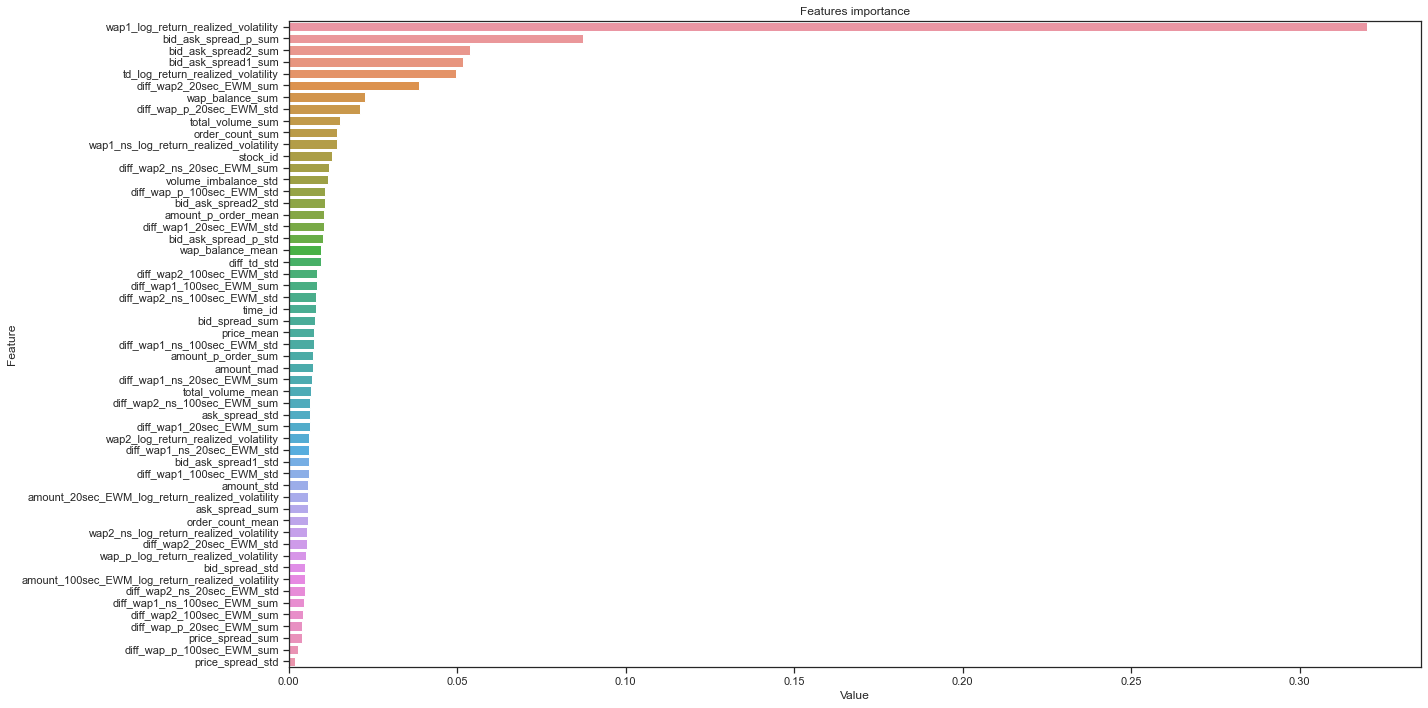

In [198]:
if not(fast):
    xgb.fit(X_train, y_train)
    plot_feature_importance(X_train, xgb, 'xgb')

## Basic LGBMRegressor model

In [199]:
if env == 'kaggle':
    lgbm = LGBMRegressor(device='gpu', random_state=42)
else:
    lgbm = LGBMRegressor(device='cpu', random_state=42)


In [200]:
# %%time
# lgbm.fit(X_train, y_train)
# evaluate('LIGHTGBM', lgbm, dic_eval, X_test, y_test)

evaluateCV('LIGHTGBM', lgbm, dic_eval, X_train, y_train)

RMSPE of the LIGHTGBM prediction: 0.277477 in 1.783 sec.


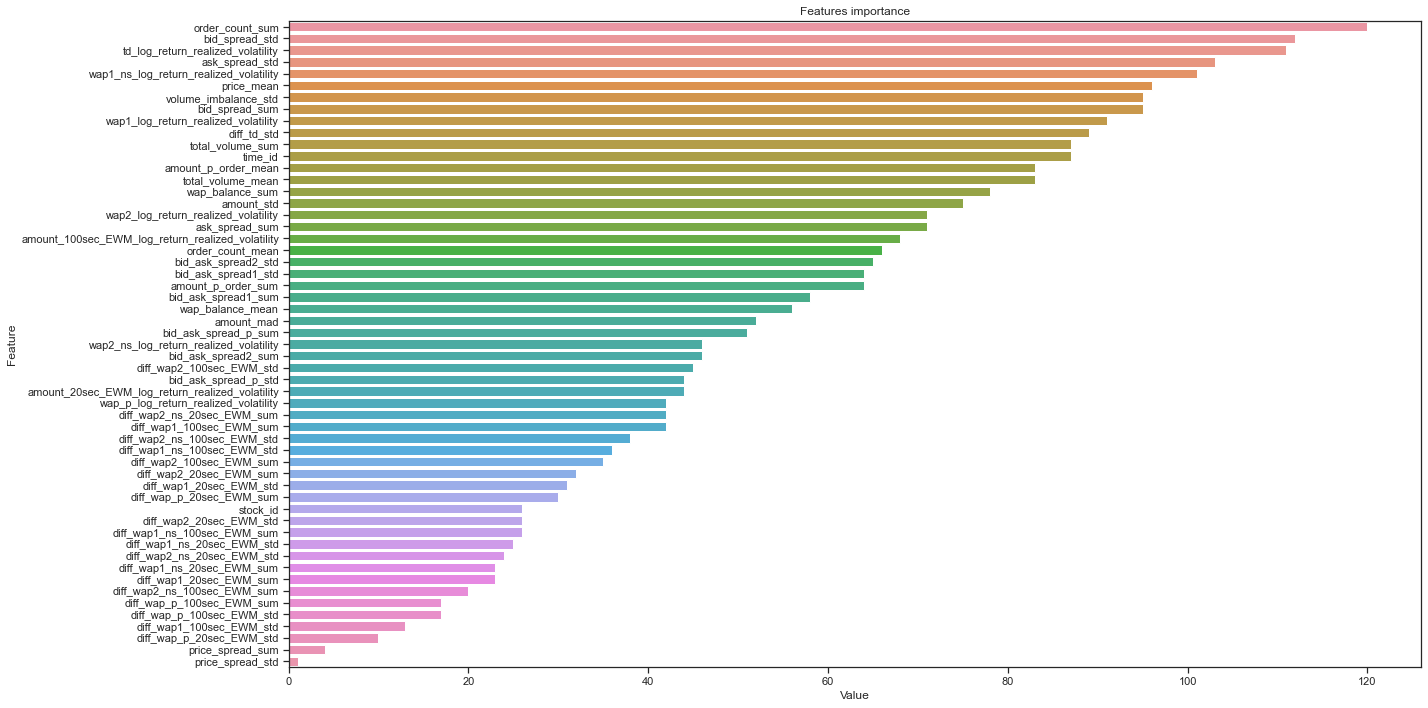

In [201]:
if not(fast):
    lgbm.fit(X_train, y_train)
    plot_feature_importance(X_train, lgbm, 'lgbm')

## Removing useless features

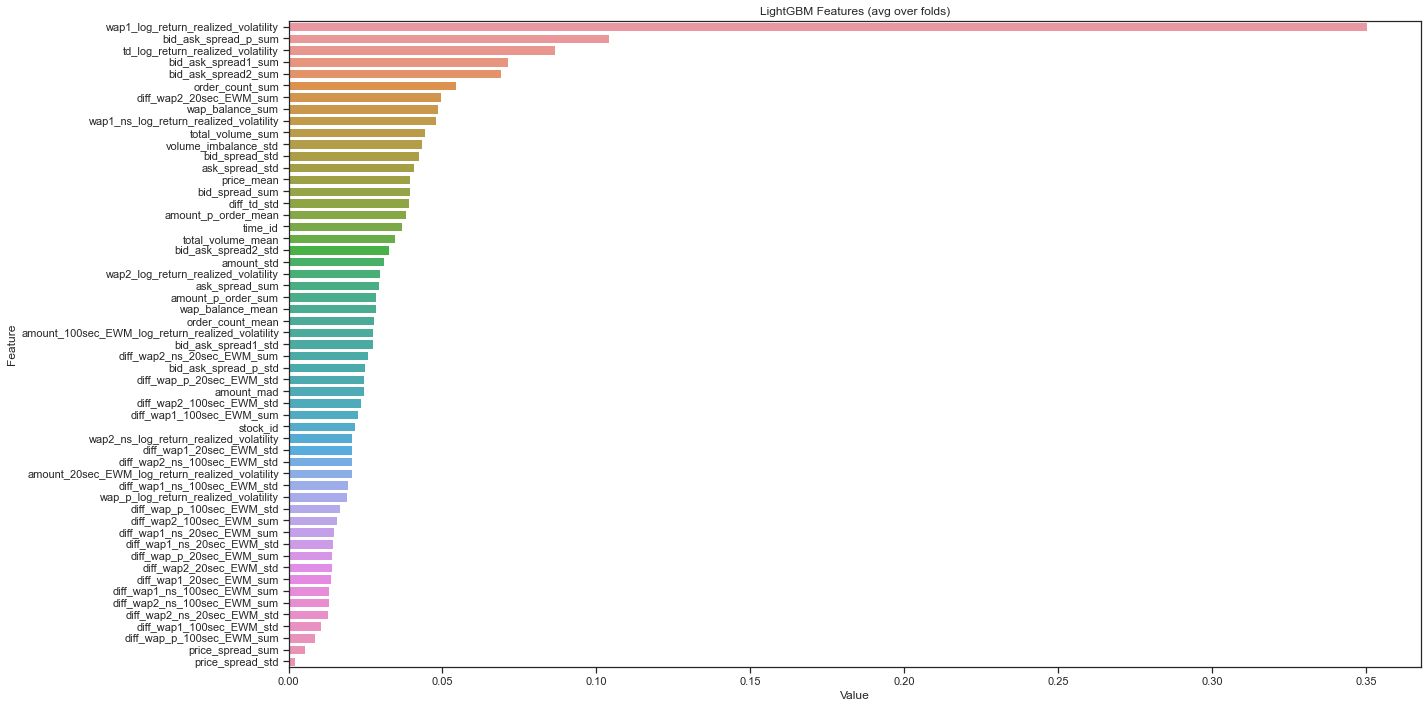

In [202]:
if not(fast):
    features_imp_lgbm_xgb = [x/sum(lgbm.feature_importances_) + y/sum(xgb.feature_importances_) for x, y in zip(lgbm.feature_importances_, xgb.feature_importances_)] 
    feature_imp = pd.DataFrame(sorted(zip(features_imp_lgbm_xgb,X_train.columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()


## CatBoost

In [203]:
cbr = CatBoostRegressor(iterations=500, random_seed=42)
# Fit model
# cbr.fit(X_train, y_train)
# evaluate('catboost', cbr, dic_eval, X_test, y_test)

evaluateCV('catboost', cbr, dic_eval, X_train, y_train)

Learning rate set to 0.091934
0:	learn: 0.0024997	total: 156ms	remaining: 1m 17s
1:	learn: 0.0023550	total: 163ms	remaining: 40.5s
2:	learn: 0.0022327	total: 172ms	remaining: 28.6s
3:	learn: 0.0021178	total: 180ms	remaining: 22.4s
4:	learn: 0.0020163	total: 188ms	remaining: 18.6s
5:	learn: 0.0019295	total: 196ms	remaining: 16.1s
6:	learn: 0.0018483	total: 206ms	remaining: 14.5s
7:	learn: 0.0017768	total: 214ms	remaining: 13.2s
8:	learn: 0.0017169	total: 222ms	remaining: 12.1s
9:	learn: 0.0016609	total: 230ms	remaining: 11.3s
10:	learn: 0.0016121	total: 238ms	remaining: 10.6s
11:	learn: 0.0015691	total: 248ms	remaining: 10.1s
12:	learn: 0.0015330	total: 256ms	remaining: 9.58s
13:	learn: 0.0015005	total: 264ms	remaining: 9.18s
14:	learn: 0.0014733	total: 279ms	remaining: 9.03s
15:	learn: 0.0014508	total: 289ms	remaining: 8.73s
16:	learn: 0.0014302	total: 296ms	remaining: 8.41s
17:	learn: 0.0014132	total: 309ms	remaining: 8.26s
18:	learn: 0.0013952	total: 322ms	remaining: 8.15s
19:	learn:

## Optuna Tuned XGBoost

Optuna va nous permettre de trouver nos meilleurs hyperparamètres.  
Il suffira ensuite d'entraîner notre modèle avec ces paramètres pour l'évaluer.

In [207]:
def objective_xgb(trial):

    param = {'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.012,0.014,0.016,0.018, 0.02, 0.025]),
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)}

    if env == 'kaggle':
        param['tree_method'] = 'gpu_hist'
    else:
        param['tree_method'] = 'hist'
    
    # model = make_pipeline(selected_scaler, XGBRegressor(**param, random_state=42))
    model = XGBRegressor(**param, random_state=42)
    
    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    model.fit(X_train , y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(X_test)
    
    return rmspe(y_test, preds)


def objective_xgbCV(trial):

    param = {
            # 'lambda': trial.suggest_loguniform('lambda', 1e-3, 1),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 1),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
            'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            # 'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
            # 'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
            }

    if env == 'kaggle':
        param['tree_method'] = 'gpu_hist'
    else:
        param['tree_method'] = 'hist'
    
    # model = make_pipeline(selected_scaler, XGBRegressor(**param, random_state=42))
    model = XGBRegressor(**param, random_state=42)

    score = cross_val_score(
        model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [208]:
%%time
study_xgb = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_xgb.optimize(objective_xgbCV, n_trials=n_trials, gc_after_trial=True)

[I 2021-10-16 17:45:47,345] A new study created in memory with name: no-name-2bfbeef4-bed9-423e-8bf1-7cf73f3d92d7
[I 2021-10-16 17:46:00,421] Trial 0 finished with value: 0.29670131924615306 and parameters: {'alpha': 0.016040475451890936, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.014, 'n_estimators': 649}. Best is trial 0 with value: 0.29670131924615306.
[I 2021-10-16 17:46:21,155] Trial 1 finished with value: 0.30252463951436204 and parameters: {'alpha': 0.1787379436987354, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 2214}. Best is trial 0 with value: 0.29670131924615306.
[I 2021-10-16 17:46:25,382] Trial 2 finished with value: 1.5128447101178562 and parameters: {'alpha': 0.2629731687093339, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 504}. Best is trial 0 with value: 0.29670131924615306.
[I 2021-10-16 17:47:01,343] Trial 3 finished with value: 0.27873463142900234 and parameters: {'alpha':

Wall time: 4min 17s


In [209]:
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

Number of finished trials: 10
Best trial: {'alpha': 0.008708213365976254, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.02, 'n_estimators': 1960}


In [210]:
if not(fast):
    optuna.visualization.plot_optimization_history(study_xgb)

In [211]:
if not(fast):
    optuna.visualization.plot_param_importances(study_xgb)

In [212]:
best_xgbparams = study_xgb.best_params
best_xgbparams

{'alpha': 0.008708213365976254,
 'colsample_bytree': 0.3,
 'subsample': 0.5,
 'learning_rate': 0.02,
 'n_estimators': 1960}

In [213]:
# best_xgbparams = {'lambda': 0.050695864818244944,
#  'alpha': 0.23319827340456734,
#  'colsample_bytree': 0.5,
#  'subsample': 0.8,
#  'learning_rate': 0.02,
#  'n_estimators': 1590,
#  'max_depth': 9,
#  'min_child_weight': 218}

if env == 'Kaggle':
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='gpu_hist')
else:
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='hist', n_jobs= - 1)

In [214]:
# %%time
# xgb_opt.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

# evaluate('XGB_opt', xgb_opt, dic_eval, X_test, y_test)

evaluateCV('XGB_opt', xgb_opt, dic_eval, X_train, y_train)

RMSPE of the XGB_opt prediction: 0.279321 in 34.411 sec.


## Optuna Tuned LGBM

In [215]:
def objective_lgbm(trial):
        param = {"device": "gpu",
                "metric": "rmse",
                "verbosity": -1,
                'learning_rate':trial.suggest_loguniform('learning_rate', 0.005, 0.5),
                "max_depth": trial.suggest_int("max_depth", 2, 500),
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                "n_estimators": trial.suggest_int("n_estimators", 100, 4000),
        #         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100000, 700000),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}

        if env == 'kaggle':
                param["device"] = "gpu"
        else:
                param["device"] = "cpu"

        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
        model = LGBMRegressor(**param)

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        preds = model.predict(X_test)
        return rmspe(y_test, preds)

def objective_lgbmCV(trial):
        param = {
                "metric": "rmse",
                "verbosity": -1,
                'learning_rate':trial.suggest_loguniform('learning_rate', 0.005, 0.5),
                "max_depth": trial.suggest_int("max_depth", 2, 500),
                # "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                # "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                "n_estimators": trial.suggest_int("n_estimators", 100, 4000),
        #         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100000, 700000),
                # "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}

        if env == 'kaggle':
                param["device"] = "gpu"
        else:
                param["device"] = "cpu"

        # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
        model = LGBMRegressor(**param, random_state=42)

        score = cross_val_score(
        # model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe, fit_params={'callbacks': [pruning_callback]}
        # ).mean()
        model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe).mean()
        return score

In [216]:
%%time
study_lgbm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_lgbm.optimize(objective_lgbmCV, n_trials=n_trials, gc_after_trial=True) # n_jobs=-1 make the calcul longer !

[I 2021-10-16 17:50:39,834] A new study created in memory with name: no-name-f3a67f45-0d29-41f0-8885-d5541061286a


[LightGBM] [Warning] bagging_fraction is set=0.5677261966361496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5677261966361496
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5677261966361496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5677261966361496
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5677261966361496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5677261966361496
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5677261966361496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5677261966361496
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:50:52,246] Trial 0 finished with value: 0.28032335856542545 and parameters: {'learning_rate': 0.01073997105898696, 'max_depth': 117, 'num_leaves': 197, 'n_estimators': 1352, 'bagging_fraction': 0.5677261966361496, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 0 with value: 0.28032335856542545.


[LightGBM] [Warning] bagging_fraction is set=0.9788649138199995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788649138199995
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9788649138199995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788649138199995
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9788649138199995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788649138199995
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9788649138199995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788649138199995
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:51:18,514] Trial 1 finished with value: 0.2888520552665351 and parameters: {'learning_rate': 0.05054498014727242, 'max_depth': 356, 'num_leaves': 102, 'n_estimators': 592, 'bagging_fraction': 0.9788649138199995, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 0 with value: 0.28032335856542545.


[LightGBM] [Warning] bagging_fraction is set=0.5393886294401964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393886294401964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5393886294401964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393886294401964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5393886294401964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393886294401964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5393886294401964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393886294401964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:52:12,475] Trial 2 finished with value: 0.29839806693054405 and parameters: {'learning_rate': 0.03523267819204896, 'max_depth': 288, 'num_leaves': 100, 'n_estimators': 3113, 'bagging_fraction': 0.5393886294401964, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 0 with value: 0.28032335856542545.


[LightGBM] [Warning] bagging_fraction is set=0.4825177195619851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4825177195619851
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4825177195619851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4825177195619851
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4825177195619851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4825177195619851
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4825177195619851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4825177195619851
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:52:45,233] Trial 3 finished with value: 0.3155360499542018 and parameters: {'learning_rate': 0.1415562019809852, 'max_depth': 441, 'num_leaves': 98, 'n_estimators': 1155, 'bagging_fraction': 0.4825177195619851, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 0 with value: 0.28032335856542545.


[LightGBM] [Warning] bagging_fraction is set=0.6360708629791039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6360708629791039
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6360708629791039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6360708629791039
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6360708629791039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6360708629791039
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6360708629791039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6360708629791039
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:53:21,522] Trial 4 finished with value: 0.32152184165334136 and parameters: {'learning_rate': 0.15759489638946167, 'max_depth': 379, 'num_leaves': 204, 'n_estimators': 3320, 'bagging_fraction': 0.6360708629791039, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 0 with value: 0.28032335856542545.


[LightGBM] [Warning] bagging_fraction is set=0.6104549883270418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6104549883270418
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6104549883270418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6104549883270418
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6104549883270418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6104549883270418
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6104549883270418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6104549883270418
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:55:56,651] Trial 5 finished with value: 0.30901744796060415 and parameters: {'learning_rate': 0.18626930275902387, 'max_depth': 352, 'num_leaves': 171, 'n_estimators': 3065, 'bagging_fraction': 0.6104549883270418, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 0 with value: 0.28032335856542545.


[LightGBM] [Warning] bagging_fraction is set=0.7286840129983267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7286840129983267
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7286840129983267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7286840129983267
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7286840129983267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7286840129983267
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7286840129983267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7286840129983267
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:56:31,066] Trial 6 finished with value: 0.31592581685313964 and parameters: {'learning_rate': 0.29783805555235543, 'max_depth': 252, 'num_leaves': 118, 'n_estimators': 935, 'bagging_fraction': 0.7286840129983267, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 0 with value: 0.28032335856542545.


[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:56:57,895] Trial 7 finished with value: 0.27909070047243245 and parameters: {'learning_rate': 0.00647246501983267, 'max_depth': 419, 'num_leaves': 76, 'n_estimators': 1917, 'bagging_fraction': 0.6600791753328665, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 7 with value: 0.27909070047243245.


[LightGBM] [Warning] bagging_fraction is set=0.9490795342850001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9490795342850001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9490795342850001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9490795342850001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9490795342850001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9490795342850001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9490795342850001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9490795342850001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:57:03,881] Trial 8 finished with value: 0.27946049718215027 and parameters: {'learning_rate': 0.011005774574214155, 'max_depth': 216, 'num_leaves': 195, 'n_estimators': 371, 'bagging_fraction': 0.9490795342850001, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 7 with value: 0.27909070047243245.


[LightGBM] [Warning] bagging_fraction is set=0.5111093007054086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5111093007054086
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5111093007054086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5111093007054086
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5111093007054086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5111093007054086
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5111093007054086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5111093007054086
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current va

[I 2021-10-16 17:57:36,863] Trial 9 finished with value: 0.32125478345137587 and parameters: {'learning_rate': 0.12201628922717793, 'max_depth': 321, 'num_leaves': 236, 'n_estimators': 2612, 'bagging_fraction': 0.5111093007054086, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 7 with value: 0.27909070047243245.


Wall time: 6min 57s


In [217]:
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)

Number of finished trials: 10
Best trial: {'learning_rate': 0.00647246501983267, 'max_depth': 419, 'num_leaves': 76, 'n_estimators': 1917, 'bagging_fraction': 0.6600791753328665, 'bagging_freq': 5, 'min_child_samples': 71}


In [218]:
if not(fast):
    optuna.visualization.plot_optimization_history(study_lgbm)

In [219]:
if not(fast):
    optuna.visualization.plot_param_importances(study_lgbm)


In [220]:
best_lgbmparams = study_lgbm.best_params
best_lgbmparams

{'learning_rate': 0.00647246501983267,
 'max_depth': 419,
 'num_leaves': 76,
 'n_estimators': 1917,
 'bagging_fraction': 0.6600791753328665,
 'bagging_freq': 5,
 'min_child_samples': 71}

In [221]:
# best_lgbmparams = {'learning_rate': 0.012206112226610026,
#     'max_depth': 176,
#     'lambda_l1': 0.0911256640760148,
#     'lambda_l2': 7.619751773104654e-07,
#     'num_leaves': 87,
#     'n_estimators': 2713,
#     'feature_fraction': 0.6744552501464487,
#     'bagging_fraction': 0.7249343934370382,
#     'bagging_freq': 7,
#     'min_child_samples': 53}

if env == 'Kaggle':
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='gpu')
else:
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='cpu')


In [222]:
# %%time
# lgbm_opt.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=100)

# evaluate('LIGHTGBM_opt', lgbm_opt, dic_eval, X_test, y_test)

evaluateCV('LIGHTGBM_opt', lgbm_opt, dic_eval, X_train, y_train)


[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6600791753328665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600791753328665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current va

## Stacking Regressor

Stack of estimators with a final regressor.

Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [224]:
if not(fast):
    if env == 'kaggle':
        tree_method='gpu_hist'
        device='gpu'
        n_jobs=None
    else:
        tree_method='hist'
        device='cpu'
        n_jobs=-1

    xgb = XGBRegressor(tree_method=tree_method, random_state = RANDOM_SEED)
    lgbm = LGBMRegressor(device=device, random_state=RANDOM_SEED)

    estimators = [('lgbm_opt', lgbm_opt),
                ('xgb_opt', xgb_opt),
                ('lgbm', lgbm),
                ('xgb', xgb)]

    stack_reg = StackingRegressor(estimators=estimators, final_estimator=None, verbose=1, n_jobs=n_jobs)

In [225]:
if not(fast):
    evaluateCV('Stack_reg', stack_reg, dic_eval, X_train, y_train)

RMSPE of the Stack_reg prediction: 0.435926 in 244.758 sec.


## Score visualization

In [ ]:
models = [k for k in dic_eval.keys()]
rmspe_scores = [val[1] for val in dic_eval.values()]

rmspe_scores, models = (list(t) for t in zip(*sorted(zip(rmspe_scores, models))))

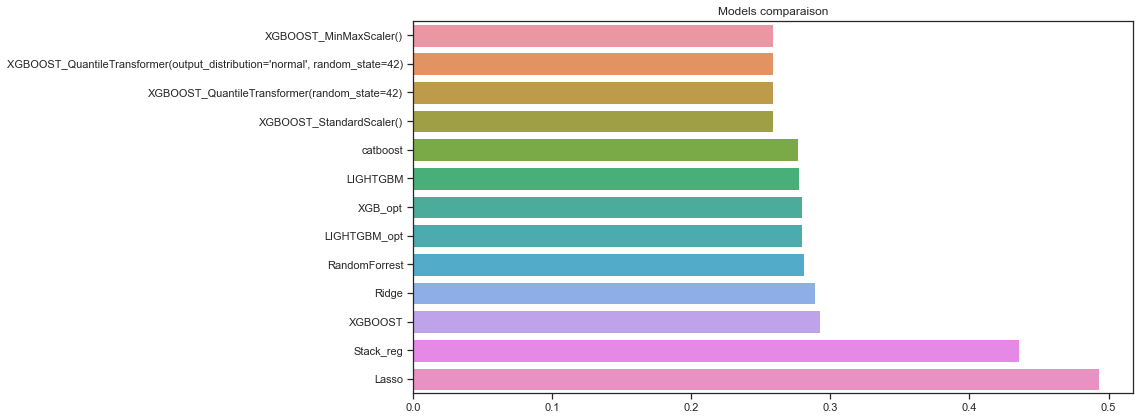

In [ ]:
plt.figure(figsize=(16,6))

sns.barplot(x=rmspe_scores, y=models)
plt.title('Models comparaison')
plt.tight_layout()

if (env == 'local' or env == 'kaggle'):
    plt.savefig(save_path + 'models_comparaison.png')
plt.show()


In [245]:
def model_selection(dic):
    rmspe_min = 1
    for key in dic.keys():
        rmspe_model = dic[key][1]
        if rmspe_model < rmspe_min:
            rmspe_min = rmspe_model
            model = dic[key][0]
            name = key
    return model, name

model_final, model_name = model_selection(dic_eval)

In [246]:
model_final.fit(X_train, y_train)

Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal',
                                     random_state=42)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=-1, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='hist',
                              validate_par

In [224]:
###############################
# Save the best model
###############################

filename = 'model_' + model_name + '.sav'
pickle.dump(model_final, open(output + filename, 'wb'))

# Submission

In [225]:
###############################
# Load a model previously saved
###############################

# model_final = pickle.load(open(output + filename, 'rb'))

In [226]:
X_test = df_test.drop(['row_id'], axis = 1)
df_pred = df_test[['row_id']]

df_pred = df_pred.assign(target = model_final.predict(X_test))
df_pred.to_csv('submission.csv', index=False)

In [228]:
pd.read_csv('submission.csv')

,row_id,target
0,0-4,0.017646
1,0-32,0.017646
2,0-34,0.017646
